In [64]:
# Step 1

In [65]:
# # prompt: write code for google drive

# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# ⚡ Quick Setup - Run after runtime reset (CPU/GPU Switch)
# Installs essential packages silently to save output clutter

!pip install dask pytz torch pytorch-forecasting pytorch-lightning \
    rich colorama matplotlib seaborn pandas numpy tensorboard \
    'lightning[extra]' pyarrow fastparquet --quiet

print("\033[92m✅ All required packages installed successfully.\033[0m")

✅ All required packages installed successfully.


In [67]:
import pytorch_forecasting
print(pytorch_forecasting.__version__)

1.4.0


In [68]:
# Standard Library
import os
import datetime
import glob
import json
import shutil
import math
import pytz
from concurrent.futures import ThreadPoolExecutor

# Third-Party Libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

# PyTorch Lightning
# from datetime import datetime
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE

ist = pytz.timezone('Asia/Kolkata')
now_ist = datetime.datetime.now(ist)
timestamp = now_ist.strftime("%Y%m%d-%H%M%S")
print(f"All Libraries are loaded : {timestamp}")

All Libraries are loaded : 20250703-163744


In [69]:
# --------- User Configurable Parameters ---------

# Data path & VM selection
parquet_path = "/content/drive/MyDrive/datasets/processed/FeatureEngcolab"

# e.g., 50, 100, 250 etc.
num_vms_to_load = 30

# Model training parameters
train_config = {
    "targets": ['cpu_utilization_ratio'],
    "time_varying_known_reals": ['time_idx', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos'],
    "group_ids": ['vm_id'],
    "max_encoder_length": 40,
    "max_prediction_length": 12,
    "hidden_size": 10,
    "dropout": 0.1,
    "learning_rate": 0.01,
    "batch_size": 32,
    "num_workers": 2,
    "early_stopping_patience": 3,
    "epochs": 1,
    "loss_fn": RMSE(),
    "output_base_dir": "/content/drive/MyDrive/output",
    "log_dir": "/content/drive/MyDrive/output/logs"
}

# VM count for folder naming (update if needed)
vm_count = f"{num_vms_to_load}VMs"

In [70]:
# --------- Helper: Generate Run Folder Name ---------

def get_run_folder_name(train_config, vm_count):
    target = "cpu"
    past = f"past{train_config['max_encoder_length']}"
    fut = f"fut{train_config['max_prediction_length']}"
    batch = f"bs{train_config['batch_size']}"
    lr = f"lr{train_config['learning_rate']:.0e}".replace('+0', '')
    hid = f"hid{train_config['hidden_size']}"

    return f"{target}_{vm_count}_{past}_{fut}_{batch}_{lr}_{hid}_{timestamp}"

In [71]:
# --------- Main Processing ---------

vm_folders = sorted([
    name.split('=')[1] for name in os.listdir(parquet_path) if name.startswith("VM=")
])

print(f"Available VMs: {vm_folders[:10]} ... Total: {len(vm_folders)}")

# Load First N VMs Dynamically [100, 250, 500, 750, 1000, 1250]

for N in [num_vms_to_load]:
    selected_vms = vm_folders[:N]

    df3 = dd.read_parquet(
        parquet_path,
        filters=[("VM", "in", selected_vms)]
    ).compute()

    print(f"✅ Loaded {N} VMs → Shape: {df3.shape}")

# print(df3.columns.tolist())
# print(df3[['Timestamp', 'time_idx']].tail())


Available VMs: ['1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006'] ... Total: 1250
✅ Loaded 30 VMs → Shape: (264533, 50)


In [72]:
# Preprocess dataframe

df3 = df3.rename(columns={'VM': 'vm_id'})

tft_df = df3.dropna(subset=[
    'cpu_utilization_ratio',
    'memory_utilization_ratio',
    'disk_total_throughput',
    'network_total_throughput'
])

# Using Dask for big data preprocessing; switch to Pandas with .compute() as most ML models need Pandas DataFrame.

tft_df = tft_df.compute() if 'dask' in str(type(tft_df)) else tft_df

print(f"Columns available: {tft_df.columns.tolist()}")

# Define target variables
# targets = ['cpu_utilization_ratio', 'memory_utilization_ratio', 'disk_total_throughput', 'network_total_throughput']

Columns available: ['Timestamp [s]', 'CPU cores', 'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]', 'Timestamp', 'time_idx', 'time_diff', 'hour', 'dayofweek', 'is_weekend', 'month', 'day', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'cpu_utilization_ratio', 'memory_utilization_ratio', 'cpu_util_percent', 'memory_util_percent', 'cpu_util_prev', 'cpu_util_diff', 'memory_util_prev', 'memory_util_diff', 'disk_total_throughput', 'disk_rolling_mean', 'disk_rolling_std', 'network_total_throughput', 'network_rolling_mean', 'network_rolling_std', 'disk_read_prev', 'disk_read_diff', 'disk_write_prev', 'disk_write_diff', 'network_received_prev', 'network_received_diff', 'network_transmitted_prev', 'network_transmitted_diff', 'network_total_pr

In [73]:
# Setup output and log folders based on run config

folder_name = get_run_folder_name(train_config, vm_count)

train_config["output_base_dir"] = os.path.join(train_config["output_base_dir"], folder_name)
train_config["log_dir"] = os.path.join(train_config["log_dir"], folder_name)

os.makedirs(train_config["output_base_dir"], exist_ok=True)
os.makedirs(train_config["log_dir"], exist_ok=True)

print("Output directory:", train_config["output_base_dir"])
print("Log directory:", train_config["log_dir"])

# Now you can proceed to model training using `tft_df` and `train_config` as usual.

Output directory: /content/drive/MyDrive/output/cpu_30VMs_past40_fut12_bs32_lr1e-02_hid10_20250703-163744
Log directory: /content/drive/MyDrive/output/logs/cpu_30VMs_past40_fut12_bs32_lr1e-02_hid10_20250703-163744


In [74]:
import math

# Basic Dataset Summary
print(f"\n✅ Dataset Summary:")
print(f"- Min time_idx      : {tft_df['time_idx'].min()}")
print(f"- Max time_idx      : {tft_df['time_idx'].max()}")
print(f"- Total rows        : {len(tft_df):,}")
print(f"- Batch size config : {train_config['batch_size']}")

# Train/Val Split Calculation
max_time_idx = tft_df['time_idx'].max()
split_point = max_time_idx * 0.8

train_rows = (tft_df['time_idx'] <= split_point).sum()
val_rows = (tft_df['time_idx'] > split_point).sum()
total_rows = len(tft_df)
val_pct = 100 * val_rows / total_rows

print(f"\n✅ Train/Validation Split:")
print(f"- Split point (time_idx > {split_point:.2f})")
print(f"- Train rows       : {train_rows:,}")
print(f"- Validation rows  : {val_rows:,} ({val_pct:.2f}%)")

# Important for model creation
val_df = tft_df[tft_df['time_idx'] > split_point]

# Validation Window Stats
val_points = len(val_df)
min_required = train_config['max_encoder_length'] + train_config['max_prediction_length']
total_val_windows = val_points - min_required + 1
expected_val_batches = math.ceil(total_val_windows / train_config['batch_size'])

print(f"\n✅ Validation Window Stats:")
print(f"- Validation points : {val_points:,}")
print(f"- Min required points: {min_required}")
print(f"- Total windows      : {total_val_windows:,}")
print(f"- Expected batches   : {expected_val_batches:,}")


✅ Dataset Summary:
- Min time_idx      : 0
- Max time_idx      : 8639
- Total rows        : 229,536
- Batch size config : 32

✅ Train/Validation Split:
- Split point (time_idx > 6911.20)
- Train rows       : 186,537
- Validation rows  : 42,999 (18.73%)

✅ Validation Window Stats:
- Validation points : 42,999
- Min required points: 52
- Total windows      : 42,948
- Expected batches   : 1,343


In [75]:
# Reset index (important for unique indexing)
tft_df = tft_df.reset_index(drop=True)

# Prepare TimeSeriesDataSet for training portion (80%)
dataset = TimeSeriesDataSet(
    tft_df[tft_df.time_idx <= tft_df['time_idx'].max() * 0.8],
    time_idx='time_idx',
    target=train_config["targets"][0],  # 'cpu_utilization_ratio' here
    group_ids=train_config["group_ids"],
    max_encoder_length=train_config["max_encoder_length"],
    max_prediction_length=train_config["max_prediction_length"],
    time_varying_known_reals=train_config["time_varying_known_reals"],
    time_varying_unknown_reals=train_config["targets"],
    target_normalizer=GroupNormalizer(groups=train_config["group_ids"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# Validation dataset for prediction (no randomization, full data)
# ✅ "TimeSeriesDataSet applies sliding window logic on the training data,
# using the full configuration like past steps, future steps, groups, and prepares the dataset accordingly."

val_df = val_df.reset_index(drop=True) # Reset index of val_df

val_dataset = TimeSeriesDataSet.from_dataset(
    dataset, val_df, predict=True, stop_randomization=True
)

# Create dataloaders

train_dataloader = dataset.to_dataloader(
    train=True,
    batch_size=train_config["batch_size"],
    num_workers=train_config["num_workers"]
)

val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=train_config["batch_size"],
    num_workers=train_config["num_workers"]
)


print(f"✅ Dataset and dataloaders ready. Train batches: {len(train_dataloader)}, Val batches: {len(val_dataloader)}")

✅ Dataset and dataloaders ready. Train batches: 5781, Val batches: 1


In [76]:
# Step 7

In [78]:
# Logging & Callbacks

from pytorch_lightning.callbacks import EarlyStopping

for target in train_config["targets"]:
    print(f"\n🔁 Training for target: {target}")

    run_dir = os.path.join(train_config["output_base_dir"], f"{target}_run_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)

    # Save Raw cleaned DF for inspection, tft_df is pandas dataframe.

    tft_df.to_csv(f"{run_dir}/tft_df.csv", index=False)

    # Save structured TimeSeriesDataset for future reuse Timeseries dataset object
    # Dataset structure & metadata for reloading

    dataset.save(f"{run_dir}/tft_df")

    # Setup logging & checkpointing
    logger = CSVLogger(save_dir=train_config["log_dir"], name=f"{target}_log")

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=run_dir,
        filename="tft-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        save_last=True,
        mode="min"
    )

    early_stopping = EarlyStopping(monitor="val_loss", patience=train_config["early_stopping_patience"], mode="min")


🔁 Training for target: cpu_utilization_ratio


In [79]:
# Step 8

In [80]:
# Model, Lightning, Trainer

In [81]:
import pytorch_lightning as pl

class TFTLightningModule(pl.LightningModule):
    def __init__(self, tft_model: TemporalFusionTransformer, learning_rate: float, loss_fn: torch.nn.Module):
        super().__init__()
        self.tft_model = tft_model
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.prediction, y) # Extract prediction from output
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat.prediction, y) # Extract prediction from output
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Create the TFT model
tft_model = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=train_config["learning_rate"],
    hidden_size=train_config["hidden_size"],
    dropout=train_config["dropout"],
    loss=train_config["loss_fn"],
    log_interval=10,
    reduce_on_plateau_patience=4
)

# Wrap the TFT model in a LightningModule
model = TFTLightningModule(
    tft_model=tft_model,
    learning_rate=train_config["learning_rate"],
    loss_fn=train_config["loss_fn"]
)

# Setup Trainer
if torch.cuda.is_available():
    accelerator = "gpu"
    devices = 1
else:
    accelerator = "cpu"
    devices = 1

trainer = Trainer(
    max_epochs=train_config["epochs"],
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping],
    enable_checkpointing=True
)

# Fit the model
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /content/drive/MyDrive/output/cpu_30VMs_past40_fut12_bs32_lr1e-02_hid10_20250703-163744/cpu_utilization_ratio_run_20250703-163744 exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 15.3 K | train
1 | loss_fn   | RMSE                      | 0      | train
----------------------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
454   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 25. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [82]:
# Step 9

In [83]:
# 🔍 Make raw predictions on validation set

/tmp/ipython-input-84-4293948460.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


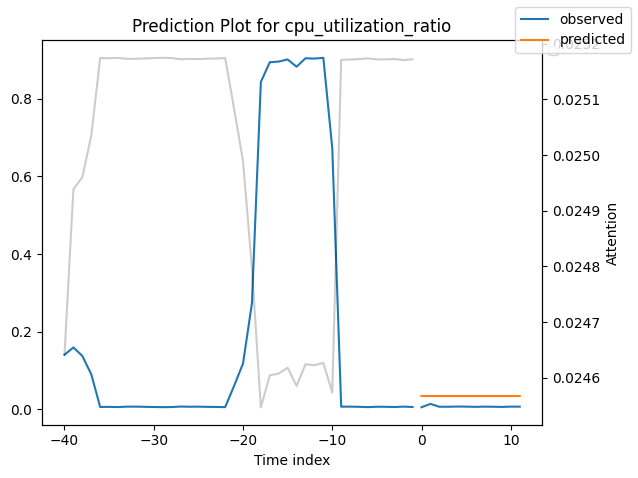

✅ Prediction plot saved at: /content/drive/MyDrive/output/cpu_30VMs_past40_fut12_bs32_lr1e-02_hid10_20250703-163744/cpu_utilization_ratio_run_20250703-163744/plot.png
✅ Forecast values saved to: /content/drive/MyDrive/output/cpu_30VMs_past40_fut12_bs32_lr1e-02_hid10_20250703-163744/cpu_utilization_ratio_run_20250703-163744/predictions.csv


In [84]:
# 🔮 Step 1: Make raw predictions on validation set
prediction_output = model.tft_model.predict(
    val_dataloader, mode='raw', return_x=True
)

# ✅ Step 2: Extract input and output
x = prediction_output.x
predictions = prediction_output.output

# ✅ Step 3: Extract forecast values as numpy array (for CSV export)
forecast = predictions.prediction[0].detach().cpu().numpy()

# ✅ Step 4: Plot forecast using built-in TFT visualization
fig = model.tft_model.plot_prediction(
    x, predictions, idx=0, show_future_observed=True
)
plt.title(f"Prediction Plot for {target}")

# ✅ Reduce legend size and move it neatly outside
plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize='small',      # You can try 'small', 'x-small', numeric values like 8
    frameon=True,          # Adds box around legend for clarity
)

plt.tight_layout()
plt.show()

# ✅ Step 5: Save the plot as PNG
plt.savefig(f"{run_dir}/plot.png", bbox_inches='tight')  # Ensure nothing gets cut off
plt.close()
print(f"✅ Prediction plot saved at: {run_dir}/plot.png")

# ✅ Step 6: Save forecast to CSV
pd.DataFrame(forecast, columns=[f'{target}_forecast']).to_csv(
    f"{run_dir}/predictions.csv", index=False
)
print(f"✅ Forecast values saved to: {run_dir}/predictions.csv")

In [85]:
# Predicted CPU Utilization next future steps based on above config.

In [86]:
print(forecast)
print(type(forecast))
print(forecast.shape)

[[0.0345793 ]
 [0.03457368]
 [0.03457497]
 [0.03457656]
 [0.03450827]
 [0.03451066]
 [0.03451395]
 [0.03451896]
 [0.03452684]
 [0.03453802]
 [0.03455016]
 [0.03455964]]
<class 'numpy.ndarray'>
(12, 1)


In [87]:
# Step 10

In [88]:
# Spike Detection & Save Metadata

In [89]:
# 🔍 Simple spike detection based on 95th percentile threshold
spikes = forecast > np.percentile(forecast, 95)

# Save run notes and spike count
with open(f"{run_dir}/notes.txt", "w") as f:
    f.write(f"Target: {target}\n")
    f.write(f"Spikes > 95th percentile: {int(spikes.sum())}\n")
    f.write("Review plot.png and predictions.csv for further insights.\n")

# 💾 Save training config for reproducibility
# Create a serializable version of train_config
serializable_train_config = train_config.copy()
# Replace the non-serializable loss_fn object with its name
serializable_train_config["loss_fn"] = serializable_train_config["loss_fn"].__class__.__name__

with open(f"{run_dir}/modelconfig.json", "w") as f:
    json.dump(serializable_train_config, f, indent=2)

print(f"✅ Run complete. Outputs saved at: {run_dir}")

✅ Run complete. Outputs saved at: /content/drive/MyDrive/output/cpu_30VMs_past40_fut12_bs32_lr1e-02_hid10_20250703-163744/cpu_utilization_ratio_run_20250703-163744


In [90]:
forecast_path = os.path.join(run_dir, "predictions.csv")
print(f"✅ Forecast values saved to: {forecast_path}")

✅ Forecast values saved to: /content/drive/MyDrive/output/cpu_30VMs_past40_fut12_bs32_lr1e-02_hid10_20250703-163744/cpu_utilization_ratio_run_20250703-163744/predictions.csv


In [ ]:
# Command to inspect .ckpt

ckpt = torch.load("path/to/tft-epoch=01-val_loss=0.04.ckpt", map_location=torch.device('cpu'))
print(ckpt.keys())

In [ ]:
print(ckpt["epoch"])             # Epoch number
print(ckpt["global_step"])       # Total steps
print(ckpt["hyper_parameters"])  # Saved hyperparameters